Design a simple linear model to give some insights of traffic demand for LGA airport
Two datasets : 

1.   **LGAVehicleByHour.csv(target variables:vehicle_count)**
2.   **LGAFlightArrival.csv(number of incoming domestic flights arriving LGA)**



In [2]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 7.3 MB/s 
     |████████████████████████████████| 16.7 MB 230 kB/s 
     |████████████████████████████████| 6.3 MB 6.3 MB/s 


In [3]:
# import packages
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
import datetime as dt
from sklearn import linear_model
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from scipy import stats

# suppress warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# import and curate the dataset
url1 = 'https://raw.githubusercontent.com/RaeNini/Data-Analysis1-LGA-Transportation-Prediction/main/LGAFlightArrival.csv?token=GHSAT0AAAAAABQ55GV5MQQYOJUGKH2MWQDIYSKBNZQ'
FlightArrival = pd.read_csv(url1)
from google.colab import files
uploaded = files.upload()
TaxiRidership =pd.read_csv('/content/LGAVehicleByHour.csv')


Saving LGAVehicleByHour.csv to LGAVehicleByHour.csv


# **Data Preparation**

In [6]:
TaxiRidership.head()

,DOLocationID,Date,vehicle_count
0,1,2018-01-01 00:00,0.0
1,2,2018-01-01 00:00,0.0
2,3,2018-01-01 00:00,0.0
3,4,2018-01-01 00:00,0.0
4,5,2018-01-01 00:00,0.0


In [8]:
FlightArrival.head()

,Date,arrivals
0,18/1/1 0:00,3
1,18/1/1 1:00,0
2,18/1/1 2:00,1
3,18/1/1 3:00,0
4,18/1/1 4:00,0


In [9]:
# convert the 'date' feature into 'dt.datetime' format. This is for later creating dummy variables
TaxiRidership.Date = pd.to_datetime(TaxiRidership.Date)
FlightArrival.Date = pd.to_datetime(FlightArrival.Date, format='%y/%m/%d %H:%M')

In [10]:
#get day of the week; monday - 0, sunday - 6
TaxiRidership['DOW']=pd.DatetimeIndex(TaxiRidership.Date).weekday

In [11]:
#get day from beginning of the year, hour and day of the week from datetime
TaxiRidership['Hour']=pd.DatetimeIndex(TaxiRidership.Date).hour

In [12]:
#get day from beginning of the year
TaxiRidership['day']=((TaxiRidership.Date-dt.datetime(2018,1,1))/dt.timedelta(days = 1)).astype(int)

In [13]:
taxi = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=Shapefile')
taxi.head()


,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


In [14]:
#TaxiRidership
#get the number of riderships by taxi zone of origin and each day of week

tripsByDOW = TaxiRidership[['DOLocationID','DOW', 'vehicle_count']].groupby(
                                                    ['DOW', 'DOLocationID'], as_index=False).sum()
tripsByDOW.head()

,DOW,DOLocationID,vehicle_count
0,0,1,1049.0
1,0,2,0.0
2,0,3,462.0
3,0,4,2411.0
4,0,5,18.0


# **Data Visulization: Distribution of total ridership from LGA on each day of week.**

In [15]:
tripsViz = taxi.merge(tripsByDOW, left_on='location_i', right_on='DOLocationID')
tripsViz.head()


,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,DOW,DOLocationID,vehicle_count
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",0,1,1049.0
1,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",1,1,1020.0
2,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",2,1,969.0
3,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",3,1,1009.0
4,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",4,1,1294.0


In [16]:
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

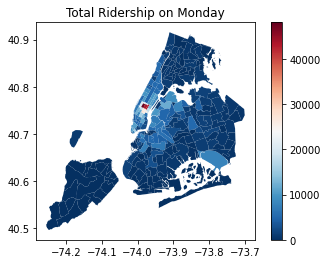

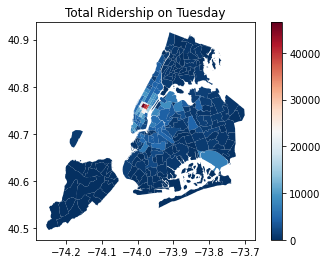

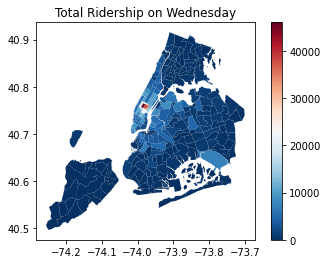

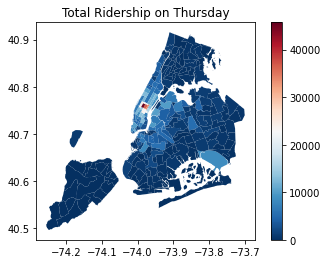

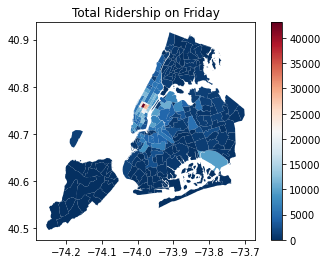

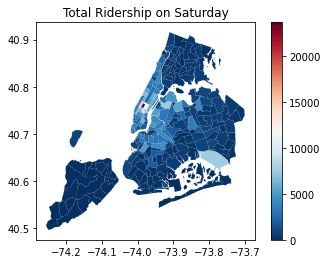

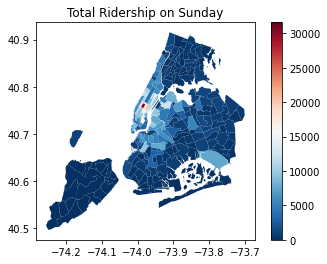

In [17]:
for i in tripsViz['DOW'].unique():
    
    tripsViz[tripsViz.DOW==i].plot(column='vehicle_count', cmap='RdBu_r', legend=True) 
    plt.title('Total Ridership on %s' % week[i])

plt.show()

# **Data Preprocessing**

In [18]:
#aggregate ridership to date-hour level 
#(over the entire city for all the drop off locations aggregated together), merge with the flight arrival data

In [19]:
#get the taxi ridership date-hour level aggregation output
tripsByHour = TaxiRidership.resample('H', on='Date').agg({'vehicle_count':'sum','DOW':'mean','day':'mean','Hour':'mean'})
tripsByHour
tripsByHour2 = tripsByHour.copy(deep=False)


In [20]:
#merge tripsByHour with flight arrival data
tripsByHour = tripsByHour.sort_values('Date')
FlightArrival = FlightArrival.sort_values('Date')
tripsMerge = pd.merge_asof(tripsByHour, FlightArrival, on='Date')
tripsMerge

,Date,vehicle_count,DOW,day,Hour,arrivals
0,2018-01-01 00:00:00,142.0,0.0,0.0,0.0,3
1,2018-01-01 01:00:00,23.0,0.0,0.0,1.0,0
2,2018-01-01 02:00:00,2.0,0.0,0.0,2.0,1
3,2018-01-01 03:00:00,1.0,0.0,0.0,3.0,0
4,2018-01-01 04:00:00,13.0,0.0,0.0,4.0,0
...,...,...,...,...,...,...
8755,2018-12-31 19:00:00,467.0,0.0,364.0,19.0,11
8756,2018-12-31 20:00:00,599.0,0.0,364.0,20.0,13
8757,2018-12-31 21:00:00,384.0,0.0,364.0,21.0,8
8758,2018-12-31 22:00:00,410.0,0.0,364.0,22.0,8


In [21]:
tripsByHour2 = tripsByHour2.sort_values('Date')
FlightArrival = FlightArrival.sort_values('Date')
tripsMerge2 = pd.merge_asof(tripsByHour2, FlightArrival, on='Date')
tripsMerge2.head()

,Date,vehicle_count,DOW,day,Hour,arrivals
0,2018-01-01 00:00:00,142.0,0.0,0.0,0.0,3
1,2018-01-01 01:00:00,23.0,0.0,0.0,1.0,0
2,2018-01-01 02:00:00,2.0,0.0,0.0,2.0,1
3,2018-01-01 03:00:00,1.0,0.0,0.0,3.0,0
4,2018-01-01 04:00:00,13.0,0.0,0.0,4.0,0


In [23]:
for x in range(12):
   tripsMerge['lag'+str(x)]= tripsMerge['arrivals'].shift(x)
tripsMerge.head()

,Date,vehicle_count,DOW,day,Hour,arrivals,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11
0,2018-01-01 00:00:00,142.0,0.0,0.0,0.0,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 01:00:00,23.0,0.0,0.0,1.0,0,0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 02:00:00,2.0,0.0,0.0,2.0,1,1,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 03:00:00,1.0,0.0,0.0,3.0,0,0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 04:00:00,13.0,0.0,0.0,4.0,0,0,0.0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
tripsMerge[['vehicle_count', 'arrivals']].describe()

,vehicle_count,arrivals
count,8760.000000,8760.000000
mean,619.968265,18.688699
std,451.871984,13.332222
min,0.000000,0.000000
25%,81.750000,2.000000
50%,684.000000,23.000000
75%,988.000000,30.000000
max,2028.000000,44.000000


The total number of records is 8760

# **Data Exploration**

Plot the timeline of the **vehicle_count** and **arrivals** for the month having the highest taxi ridership (the sum of vehicle count in the whole month). 

In [28]:

tripsMerge2['Month'] = tripsMerge2['Date'].dt.month
tripsMerge2
tripsMerge3 = tripsMerge2.groupby(['Month','DOW','Date']).\
            agg({'vehicle_count':'sum','arrivals':'sum'}).reset_index()
tripsMerge3 = tripsMerge3.sort_values(by='Month')
tripsMerge3.head()

,Month,DOW,Date,vehicle_count,arrivals
0,1,0.0,2018-01-01 00:00:00,142.0,3
490,1,4.0,2018-01-12 10:00:00,579.0,23
491,1,4.0,2018-01-12 11:00:00,748.0,27
492,1,4.0,2018-01-12 12:00:00,730.0,20
493,1,4.0,2018-01-12 13:00:00,671.0,23


In [29]:
tripsMerge3['Date'].dt.month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [30]:
#locate the correct month
mon_rid = []

for i in range(1, 13):
    mon_rid.append(sum(tripsMerge3[tripsMerge3['Date'].dt.month==i]['vehicle_count']))
    
print('Max ridership is {}, in month {}.'.format(max(mon_rid), (mon_rid.index(max(mon_rid))+1)))


Max ridership is 507190.0, in month 10.


In [31]:
stan1 = tripsMerge3[tripsMerge3['Date'].dt.month==10][['Date', 'vehicle_count']].set_index('Date')
stan2 = tripsMerge3[tripsMerge3['Date'].dt.month==10][['Date', 'arrivals']].set_index('Date')

scaler = preprocessing.StandardScaler()
stan1Std = scaler.fit_transform(np.array(stan1['vehicle_count']).reshape(-1,1))
stan2Std = scaler.fit_transform(np.array(stan2['arrivals']).reshape(-1,1))


In [32]:

stan1Std = pd.DataFrame({'index':stan1.index, 'Std':stan1Std.reshape(len(stan1),)}).set_index('index')
stan1 = pd.concat([stan1, stan1Std], axis=1)
stan1.head()

,vehicle_count,Std
2018-10-12 17:00:00,1165.0,0.990112
2018-10-12 16:00:00,1059.0,0.772952
2018-10-12 15:00:00,954.0,0.557841
2018-10-12 12:00:00,925.0,0.498429
2018-10-12 13:00:00,940.0,0.529160


In [33]:
stan2Std = pd.DataFrame({'index':stan2.index, 'Std':stan2Std.reshape(len(stan2),)}).set_index('index')
stan2 = pd.concat([stan2, stan2Std], axis=1)
stan2.head()

,arrivals,Std
2018-10-12 17:00:00,31,0.833779
2018-10-12 16:00:00,35,1.126422
2018-10-12 15:00:00,31,0.833779
2018-10-12 12:00:00,27,0.541135
2018-10-12 13:00:00,27,0.541135


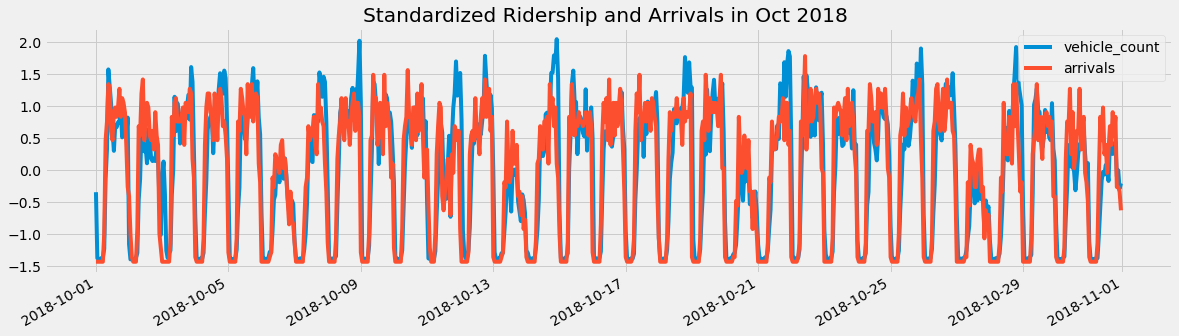

In [36]:
#Plot the timeline
fig, ax = plt.subplots(1, figsize=(18, 5))
stan1['Std'].plot(ax=ax, label='vehicle_count')
stan2['Std'].plot(ax=ax, label='arrivals')
plt.legend()
plt.title('Standardized Ridership and Arrivals in Oct 2018 ')
plt.show()

# **Build Linear Regression Model of FHV and taxi ridership vs Arrivals data**

In [37]:
#split the data into training, validation and test samples 
#(first 90 days for training, next 180 for validation, last 90 for test)
#slice the data in three pieces 
validation=tripsMerge[(tripsMerge.day>=90)&(tripsMerge.day<270)]
testdata=tripsMerge[(tripsMerge.day>=271)]
traindata=tripsMerge[(tripsMerge.day<90)]

traindata2=traindata
validationf=validation
testdataf=testdata
validation.shape


(4320, 18)

In [38]:
testdata.shape

(2256, 18)

In [39]:
traindata.shape

(2160, 18)

In [40]:
#Build an OLS model with intercept over the training dataset using arrivals as a sole predictor for vehicle_count
lm2 = smf.ols(formula = 'vehicle_count ~ arrivals', data = traindata).fit()
print(lm2.summary())

#p-value for arrival
#p-value of arrivals is less than 0.05, which means it is significant



                            OLS Regression Results                            
Dep. Variable:          vehicle_count   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     5657.
Date:                Mon, 04 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:03:52   Log-Likelihood:                -14690.
No. Observations:                2160   AIC:                         2.938e+04
Df Residuals:                    2158   BIC:                         2.939e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     75.8315      7.772      9.757      0.0

In [42]:
#Report the 99% confidence interval for arrival's coefficient.
lm2.conf_int(alpha=0.01) # 99% CI


,0,1
Intercept,55.794760,95.868142
arrivals,25.382394,27.184322


so the 99%CI could be [25.382394,27.184322]

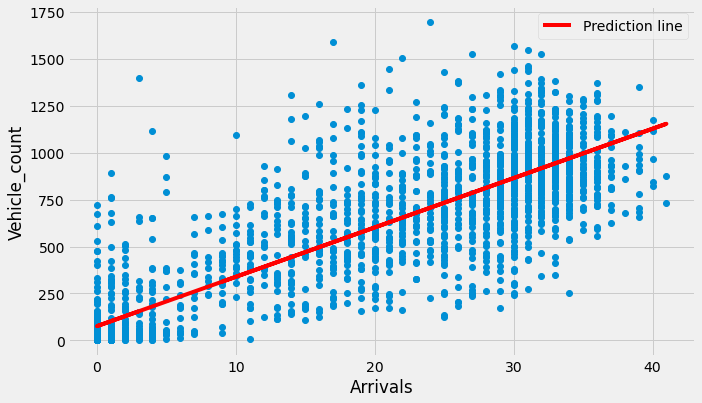

In [43]:
#Scatter plot for taxi ridership and flight arrival, include the predictive line from linear regression report.
plt.figure(figsize=(10,6))
plt.plot(traindata['arrivals'], traindata['vehicle_count'], 'o') 
plt.xlabel('Arrivals') 
plt.ylabel('Vehicle_count')
plt.plot(traindata['arrivals'], lm2.predict(), '-r', label='Prediction line') 
plt.legend()
plt.show()

Then we consider the impact of immediate history of arrivals and add time lags into the regression above.

[Since the **vehicle_count** might be more related to historical values of flight arrivals(lag) rather than immediate **arrivals**]

In [44]:
#use this operator to generate the regression formulae
' + '.join(traindata.columns[5:18])

'arrivals + lag0 + lag1 + lag2 + lag3 + lag4 + lag5 + lag6 + lag7 + lag8 + lag9 + lag10 + lag11'

In [45]:
lm = smf.ols(formula = 'vehicle_count ~ ' + ' + '.join(traindata.columns[5:18]), data = traindata).fit()
print(lm.summary())
#The variables including arrivals, lag1, lag2, lag3 and lag9, have a statistically significant impact according to p-values



                            OLS Regression Results                            
Dep. Variable:          vehicle_count   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     1083.
Date:                Mon, 04 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:11:31   Log-Likelihood:                -13892.
No. Observations:                2149   AIC:                         2.781e+04
Df Residuals:                    2136   BIC:                         2.788e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -58.9224      9.097     -6.477      0.0

Then we add categorical varibles for day of week and hour of the day:

Taxi ridership and arrivals follow a periodic temporal pattern, which is true for most traffic flows. 

So we introduce dummy variables (1 for True and 0 for False) to form people's traveling patterns during different time periods.

**Perform the regression of vehicle_count ridership against arrivals, lags, and temporal categorical variables**

In [46]:
#adding categorical variables for day of week and hour of the day.
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [47]:
traindata2.head()

,Date,vehicle_count,DOW,day,Hour,arrivals,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11
0,2018-01-01 00:00:00,142.0,0.0,0.0,0.0,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 01:00:00,23.0,0.0,0.0,1.0,0,0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 02:00:00,2.0,0.0,0.0,2.0,1,1,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 03:00:00,1.0,0.0,0.0,3.0,0,0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 04:00:00,13.0,0.0,0.0,4.0,0,0,0.0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
Hour = pd.get_dummies(traindata2['Hour']).rename(
                                        columns=dict(zip(range(24), list('Hour_%d' % i for i in range(24)))))
DOW = pd.get_dummies(traindata2['DOW']).rename(
                                        columns=dict(zip(range(7), week)))

dummy = pd.concat([DOW, Hour], axis=1)
dummy.head()


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Hour_0,Hour_1,Hour_2,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
traindatadummy = pd.concat([traindata2, dummy], axis=1)
traindatadummy

,Date,vehicle_count,DOW,day,Hour,arrivals,lag0,lag1,lag2,lag3,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,2018-01-01 00:00:00,142.0,0.0,0.0,0.0,3,3,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2018-01-01 01:00:00,23.0,0.0,0.0,1.0,0,0,3.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2018-01-01 02:00:00,2.0,0.0,0.0,2.0,1,1,0.0,3.0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2018-01-01 03:00:00,1.0,0.0,0.0,3.0,0,0,1.0,0.0,3.0,...,0,0,0,0,0,0,0,0,0,0
4,2018-01-01 04:00:00,13.0,0.0,0.0,4.0,0,0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,2018-03-31 19:00:00,278.0,5.0,89.0,19.0,11,11,16.0,20.0,27.0,...,0,0,0,0,0,1,0,0,0,0
2156,2018-03-31 20:00:00,280.0,5.0,89.0,20.0,11,11,11.0,16.0,20.0,...,0,0,0,0,0,0,1,0,0,0
2157,2018-03-31 21:00:00,420.0,5.0,89.0,21.0,16,16,11.0,11.0,16.0,...,0,0,0,0,0,0,0,1,0,0
2158,2018-03-31 22:00:00,279.0,5.0,89.0,22.0,14,14,16.0,11.0,11.0,...,0,0,0,0,0,0,0,0,1,0


In [50]:
lm = smf.ols(formula = 'vehicle_count ~ ' + '+'.join(i for i in traindatadummy.iloc[:, 5:]), data = traindatadummy).fit()
print(lm.summary())


                            OLS Regression Results                            
Dep. Variable:          vehicle_count   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     459.7
Date:                Mon, 04 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:40:27   Log-Likelihood:                -13528.
No. Observations:                2149   AIC:                         2.714e+04
Df Residuals:                    2107   BIC:                         2.738e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.1790      9.267      4.983      0.0